#### Greedy Feature Selectionの実装
`penguins_size.csv`データセットを使用してgreedy feature selectionを実装

#### 前処理
1. 欠損値が多いデータは削除
2. カテゴリカルの欠損値にはNaNを代入し新たなカテゴリとして扱う
3. one-hot encodingでダミー変数化
4. 標準化
#### 特徴量エンジニアリング
- 多項式特徴量
- 四則演算
#### Greedy Feature Selectionのクラス実装
- k-Foldで評価
- 引数にPipelineを受けとる
最終的に、精度の推移と、選択された特徴量を確認


In [34]:
# ライブラリ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold

In [8]:
# データ
df = pd.read_csv('../data/penguins_size.csv')
# sexカラムの.を欠損値にする
df.loc[df[df['sex'] == '.'].index, 'sex'] = np.nan


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [13]:
# sexカラムが欠損値の行を抽出
df[df['sex'].isna()]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


欠損値が多いカラムは削除

In [19]:
# 欠損値を削除する
# thresh=3は、欠損値が3つ以上ある行を削除する
df.dropna(thresh=3, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 21.4+ KB


In [58]:
target = 'species'
X = df.drop(target, axis=1)
y = df[target]
# 欠損値にはNanを代入して新たなカラムにする
from sklearn.impute import SimpleImputer

# strategy='constant'とすると、fill_valueで指定した値を欠損値に代入する
imputer = SimpleImputer(strategy='constant', fill_value='Nan')
imputer.set_output(transform='pandas')
X['sex'] = imputer.fit_transform(X[['sex']])

# one-hotエンコーディングをpipelineに組み込むためにクラスを作る
from sklearn.base import BaseEstimator, TransformerMixin

class GetDummies(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self

    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)


# 特徴量エンジニアリング
# 多項式特徴量
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X[['culmen_length_mm', 'culmen_depth_mm', 'culmen_length_mm^2', 'culmen_length_mm * culmen_depth_mm', 'culmen_depth_mm^2']] = poly.fit_transform(X[['culmen_length_mm', 'culmen_depth_mm']])
# 四則演算
X['culmen_diff'] = X['culmen_length_mm'] - X['culmen_depth_mm']
X['culmen_ratio'] = X['culmen_length_mm'] / X['culmen_depth_mm']

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# パイプラインを作る
pipeline = Pipeline([
    ('dummy', GetDummies()),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

n_splits = 3
cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# Greedy Feature Selectionを作成する

In [59]:
# Greedy Feature Selectionを作成する
from sklearn.base import clone

class GreedyFeatureSelection():

    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.select_features = []
        self.scores = [0]

    def select_feature(self, X, y):
        
        all_feature = X.columns
        while True:
            best_score = self.scores[-1]
            candidate_feature = None
            for feature in all_feature:
                if feature in self.select_features:
                    continue
                features = self.select_features + [feature]
                X_train = X[features]
                score = cross_val_score(self.pipeline, X_train, y, cv=self.cv, scoring='accuracy').mean()
                if score > best_score:
                    best_score = score
                    candidate_feature = feature
                
            if candidate_feature is not None:
                self.scores.append(best_score)
                self.select_features.append(candidate_feature)
            else:
                break

In [60]:
# Greedy Feature Selectionを作成する

# 最終的には
gfs = GreedyFeatureSelection(pipeline=pipeline, cv=cv)
# X, yを入れると特徴量を選択するアルゴリズムが動く
gfs.select_feature(X, y)
# それぞれの最高精度を出力
# gfs.scores
# # 選択された特徴量をリストで出力
# gfs.selected_features


In [61]:
gfs.select_features

['culmen_ratio', 'island', 'culmen_diff', 'body_mass_g']

### RFE

In [62]:
# すでに特徴量エンジニアリングしているものを利用する
X

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,culmen_length_mm^2,culmen_length_mm * culmen_depth_mm,culmen_depth_mm^2,culmen_diff,culmen_ratio
0,Torgersen,39.1,18.7,181.0,3750.0,MALE,1528.81,731.17,349.69,20.4,2.090909
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,1560.25,687.30,302.76,22.1,2.270115
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,1624.09,725.40,324.00,22.3,2.238889
4,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,1346.89,708.31,372.49,17.4,1.901554
5,Torgersen,39.3,20.6,190.0,3650.0,MALE,1544.49,809.58,424.36,18.7,1.907767
...,...,...,...,...,...,...,...,...,...,...,...
338,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,2227.84,646.64,187.69,33.5,3.445255
340,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,2190.24,669.24,204.49,32.5,3.272727
341,Biscoe,50.4,15.7,222.0,5750.0,MALE,2540.16,791.28,246.49,34.7,3.210191
342,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,2043.04,668.96,219.04,30.4,3.054054


In [63]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
rfe = RFE(DecisionTreeClassifier(), n_features_to_select=6)
X = pd.get_dummies(X, drop_first=True)
rfe.fit(X, y)
rfe.transform(X)



array([[20.4       ,  2.09090909,  0.        ,  1.        ,  1.        ,
         0.        ],
       [22.1       ,  2.27011494,  0.        ,  1.        ,  0.        ,
         0.        ],
       [22.3       ,  2.23888889,  0.        ,  1.        ,  0.        ,
         0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ,  0.        ,  1.        ,
         0.        ],
       [30.4       ,  3.05405405,  0.        ,  0.        ,  0.        ,
         0.        ],
       [33.8       ,  3.09937888,  0.        ,  0.        ,  1.        ,
         0.        ]])

In [64]:
#　ランキング
rfe.feature_names_in_[rfe.ranking_ == 1]

array(['culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_Nan'], dtype=object)

In [65]:
rfe.support_

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True])

In [67]:
# 実際の学習データではpipelineに組み込んでつかう
pipeline = Pipeline([('rfe', rfe), ('scaler', StandardScaler()), ('model', LogisticRegression())])
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
print(scores)

[1.         1.         0.99122807]


In [69]:
# RFECV
# RFECVは自動で特徴量の数を決めてくれるので指定しなくてよい
from sklearn.feature_selection import RFECV

rfecv = RFECV(DecisionTreeClassifier(), cv=cv, scoring='accuracy')
rfecv.fit(X, y)
rfecv.transform(X)

array([[20.4       ,  2.09090909,  0.        ],
       [22.1       ,  2.27011494,  0.        ],
       [22.3       ,  2.23888889,  0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ],
       [30.4       ,  3.05405405,  0.        ],
       [33.8       ,  3.09937888,  0.        ]])

In [70]:
rfecv.feature_names_in_[rfecv.support_]

array(['culmen_diff', 'culmen_ratio', 'island_Dream'], dtype=object)

In [72]:
# それぞれの特徴量を使ったときの精度を記録
rfecv.cv_results_

{'mean_test_score': array([0.8625731 , 0.97953216, 0.98830409, 0.98830409, 0.98830409,
        0.98830409, 0.98830409, 0.98830409, 0.98830409, 0.98245614,
        0.98538012, 0.98830409, 0.97660819]),
 'std_test_score': array([0.1063138 , 0.01094052, 0.00413513, 0.00413513, 0.00413513,
        0.00413513, 0.00413513, 0.00413513, 0.00413513, 0.00716225,
        0.00413513, 0.00413513, 0.00827025]),
 'split0_test_score': array([0.97368421, 0.99122807, 0.99122807, 0.99122807, 0.99122807,
        0.99122807, 0.99122807, 0.99122807, 0.99122807, 0.99122807,
        0.98245614, 0.99122807, 0.98245614]),
 'split1_test_score': array([0.89473684, 0.98245614, 0.99122807, 0.99122807, 0.99122807,
        0.99122807, 0.99122807, 0.99122807, 0.99122807, 0.97368421,
        0.99122807, 0.99122807, 0.96491228]),
 'split2_test_score': array([0.71929825, 0.96491228, 0.98245614, 0.98245614, 0.98245614,
        0.98245614, 0.98245614, 0.98245614, 0.98245614, 0.98245614,
        0.98245614, 0.98245614, 0.98

<ErrorbarContainer object of 3 artists>

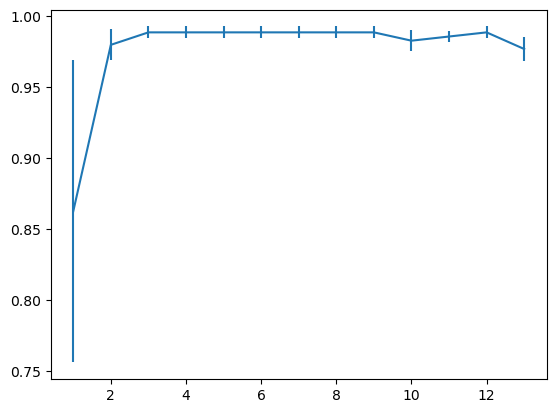

In [74]:
plt.errorbar(range(1,len(rfecv.cv_results_['mean_test_score'])+1),
             rfecv.cv_results_['mean_test_score'],
             yerr=rfecv.cv_results_['std_test_score'])

# 結果として特徴量は3個で良いことがわかる。
# 特徴量が多くても計算量が多くなるだけで精度は上がらないことがわかるs